In [1]:
print("all okay")

all okay


In [13]:
import os
import requests
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from typing import Optional,Annotated,TypedDict
from datetime import datetime
from bs4 import BeautifulSoup
from langchain_community.tools import GooglePlacesTool
from langgraph.prebuilt import tools_condition

load_dotenv()
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")
os.environ['OPENAI_API_KEY'] = os.getenv("OPENAI_API_KEY")
os.environ['GPLACES_API_KEY'] = os.getenv("GPLACES_API_KEY")

In [ ]:
from langchain_openai import ChatOpenAI
model_openai="gpt-4o"
llm=ChatOpenAI(model=model_openai)

In [3]:
# utilities 

def run_places_as_list(query: str):
    places = GooglePlacesTool()
    result = places.run(query)
    
    if isinstance(result, list):
        return result
    
    elif isinstance(result, str):
        lines = [line.strip() for line in result.strip().split("\n") if line.strip()]
        return lines

    return [result]

In [4]:
# define all tools

@tool
def search_attractions(city: str):
    """Searches for top attractions in a city for a trip in the specified month and duration."""
    
    query = f"top tourist attractions monuments museums sightseeing places in {city}"
    print(f"Search attraction query: {query} \n")
    # call google places function to fetch the list of rstaurant
    attractions=run_places_as_list(query)
    
    return attractions

@tool
def search_restaurants(city: str):
    """Searches for recommended restaurants in a city, tailored to preferences and month."""
    
    question = f"best restaurants cafes local food dining places in {city}"
    print(f"Search restaurant query: {question}\n")
    # call google places function to fetch the list of rstaurant
    restaurants=run_places_as_list(question)
    
    return restaurants

In [5]:
tools=[search_attractions,search_restaurants]

llm_with_tools=llm.bind_tools(tools)

In [6]:
# define pydantic class to define the structure of the data

class TripParams(BaseModel):
    city: str = Field(description="The primary city or destination (e.g., Delhi). Infer if not explicit.")
    country: Optional[str] = Field(description="Country, default to Italy if not specified.")
    duration: Optional[str] = Field(default="1 week", description="Trip length (e.g., '1 week', '3 days'). Infer reasonable default if missing.")
    month: Optional[str] = Field(description="Month or season of travel (e.g., 'July', 'June-August'). Infer from seasons.")
    start_date: Optional[str] = Field(description="Inferred start date in YYYY-MM-DD, based on current date if vague.")

In [7]:
parser = PydanticOutputParser(pydantic_object=TripParams)

In [8]:
def trip_maker(state:MessagesState):
    
    question = state["messages"][-1].content if hasattr(state["messages"][-1], 'content') else str(state["messages"][-1])
    
    system_prompt = """You are a helpful assistant tasked to search for a trip to a destination.
    Based on user queries, you have to analyze the approporite tool required to fetch the data and plan trip for the user to make his trip memorable.
    Always return your response as a JSON object in the following format:
    {format_instructions}"""
    
    human_prompt = "{query}"

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", human_prompt)
    ]).partial(format_instructions=parser.get_format_instructions())
    
    chain = prompt | llm_with_tools | parser
    response = chain.invoke({"query": question})
    
    return {"messages": [response]}
    

In [9]:
workflow = StateGraph(MessagesState)
workflow.add_node("trip_decision", trip_maker)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "trip_decision")
workflow.add_conditional_edges(
    "trip_decision",
    tools_condition,
)
workflow.add_edge("tools", "trip_decision")
react_graph = workflow.compile()

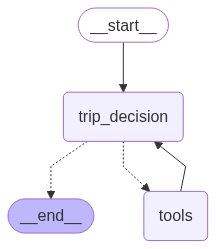

In [10]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [11]:
message=[HumanMessage(content="Plan me a trip for 1 week to lucknow city")]

In [12]:
react_graph.invoke({"messages":message})

NotImplementedError: Unsupported message type: <class '__main__.TripParams'>
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/MESSAGE_COERCION_FAILURE 

In [42]:
response=llm_with_tools.invoke("Plan me a trip for 1 week to lucknow city")

In [44]:
response

AIMessage(content="To plan your one-week trip to Lucknow, let's break it down into key categories:\n\n1. **Top Attractions to Visit**: Lucknow is known for its rich cultural heritage, historical monuments, and delicious cuisine.\n2. **Recommended Restaurants**: Enjoy the famous Awadhi cuisine.\n3. **Local Transportation**: Familiarize yourself with local transport options for easy commuting within the city.\n4. **Accommodation**: Find accommodations that suit your budget and preferences.\n5. **Shopping**: Explore local markets for traditional chikan embroidery and other handicrafts.\n6. **Cultural Experiences**: Attend local events or cultural shows if available during your visit.\n\nLet's get started with the top attractions and recommended restaurants. Could you please specify the month you'll be visiting, so that I can tailor the recommendations accordingly?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 164, 'prompt_tokens': 5998, 'to